In [1]:
cellpose_seg0 = r"output\test\2D_patch_test_0_seg.npy"
cellpose_seg1 = r"output\test\2D_patch_test_1_seg.npy"


In [78]:
import numpy as np
from cellpose import plot, utils, io, models
import matplotlib.pyplot as plt
from skimage.draw import polygon

# Load the segmentation mask
dat_0 = np.load(cellpose_seg0, allow_pickle=True).item()
# Extract the masks and generate outlines
masks_0 = dat_0['masks']
outlines_0 = utils.outlines_list(masks_0) # multiprocessing_threshold=1000



Multiprocessing is disabled for Windows


In [79]:
# Create a blank binary image to fill in the cells
filled_image_0 = np.zeros_like(masks_0, dtype=np.uint8)  # Start with black (0)

# Fill each outline's interior as white
for outline in outlines_0:
    # Ensure the outline coordinates are in integer format
    outline = np.array(outline, dtype=np.int32)
    
    # Get the rows and columns for the interior of each polygon
    rr, cc = polygon(outline[:, 1], outline[:, 0], filled_image_0.shape)
    filled_image_0[rr, cc] = 255  # Fill with white (255) inside each contour

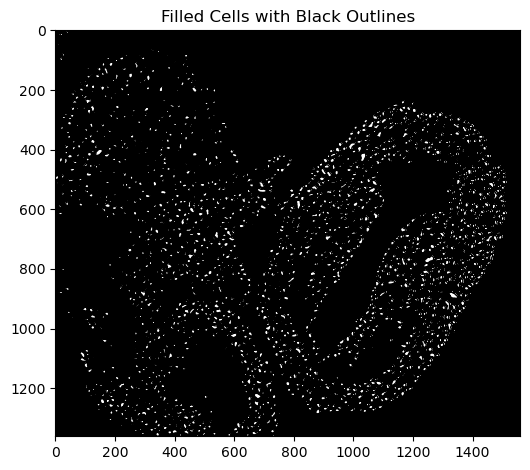

In [80]:
# Plot the filled binary image with black outlines
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(filled_image_0, cmap='gray', interpolation='none')
for outline in outlines_0:
    plt.plot(outline[:, 0], outline[:, 1], color='black', linewidth   =1)  # Add black outlines on top

ax.set_title("Filled Cells with Black Outlines")
ax.axis('on')
plt.show()

In [81]:
# Load the segmentation mask
dat_1 = np.load(cellpose_seg1, allow_pickle=True).item()
# Extract the masks and generate outlines
masks_1 = dat_1['masks']
outlines_1 = utils.outlines_list(masks_1) # multiprocessing_threshold=1000

Multiprocessing is disabled for Windows


In [82]:
# Create a blank binary image to fill in the cells
filled_image_1 = np.zeros_like(masks_1, dtype=np.uint8)  # Start with black (0)

# Fill each outline's interior as white
for outline in outlines_1:
    # Ensure the outline coordinates are in integer format
    outline = np.array(outline, dtype=np.int32)
    
    # Get the rows and columns for the interior of each polygon
    rr, cc = polygon(outline[:, 1], outline[:, 0], filled_image_1.shape)
    filled_image_1[rr, cc] = 255  # Fill with white (255) inside each contour

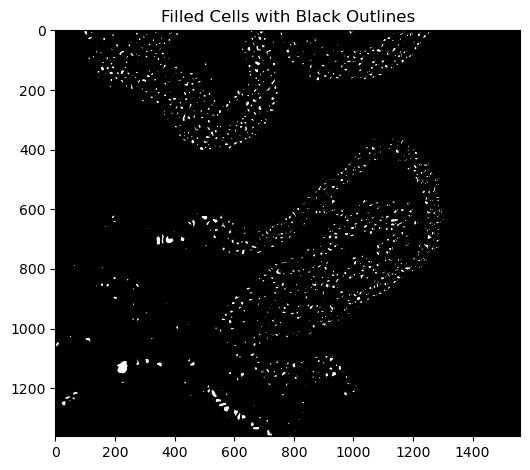

In [83]:
# Plot the filled binary image with black outlines
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(filled_image_1, cmap='gray', interpolation='none')
for outline in outlines_1:
    plt.plot(outline[:, 0], outline[:, 1], color='black', linewidth=1)  # Add black outlines on top

ax.set_title("Filled Cells with Black Outlines")
ax.axis('on')
plt.show()

In [88]:
# Define the shape of the new mask
mask_shape = (2478, 1560)

# Create a zero-filled mask
filled_image_new = np.zeros(mask_shape, dtype=np.uint8) 

# Define adjusted main segment coordinates
segments = [
    (0, 1362, 0, 1560),   # Segment 0
    (1116, 2478, 0, 1560) # Segment 1
]

# Offsets for each segment
offsets = [
    (0, 0),               # No offset for Segment 0
    (1116, 0)             # Offset for Segment 1 (row offset, column offset)
]

# New outline list
new_outlines = []

# Fill each outline's interior as white
for outline in outlines_0:
    # Add [1116, 0] to each coordinate in the outline
    outline = np.array(outline, dtype=np.int32) + np.array([0, 0], dtype=np.int32)
    
    # Get the rows and columns for the interior of each polygon
    rr, cc = polygon(outline[:, 1], outline[:, 0], filled_image_new.shape)
    filled_image_new[rr, cc] = 255  # Fill with white (255) inside each contour

# Fill each outline's interior as white
for outline in outlines_1:
    # Add [1116, 0] to each coordinate in the outline
    outline = np.array(outline, dtype=np.int32) + np.array([0, 1116], dtype=np.int32)
    
    # Get the rows and columns for the interior of each polygon
    rr, cc = polygon(outline[:, 1], outline[:, 0], filled_image_new.shape)
    filled_image_new[rr, cc] = 255  # Fill with white (255) inside each contour

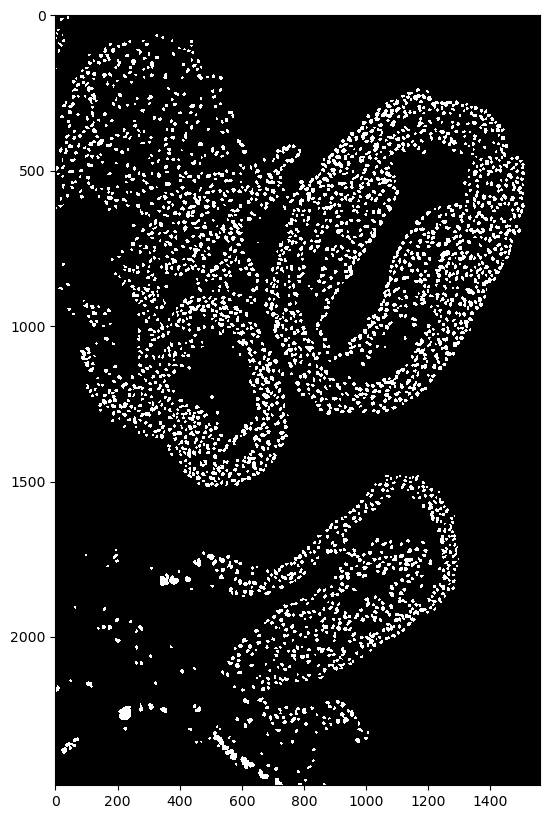

In [89]:
# Plot the filled binary image with black outlines
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(filled_image_new, cmap='gray', interpolation='none')

In [65]:
# import numpy as np

# Define adjusted main segment coordinates
segments = [
    (0, 1362, 0, 1560),   # Segment 0
    (1116, 2478, 0, 1560) # Segment 1
]

# Offsets for each segment
offsets = [
    (0, 0),               # No offset for Segment 0
    (1116, 0)             # Offset for Segment 1 (row offset, column offset)
]

# New outline list
new_outlines = []


# Function to map segmentation outlines back to original coordinates
def map_to_original_coordinates(outlines, offset):
    """
    Maps segmentation outlines back to the original image coordinates.

    Parameters:
        outlines (list of ndarrays): List of segmentation outlines (N x 2 arrays).
        offset (tuple): Offset (min_x, min_y) of the cropped region in the original image.

    Returns:
        list of ndarrays: Transformed outlines in original coordinates.
    """
    min_x, min_y = offset
    return [outline + np.array([min_x, min_y]) for outline in outlines]

offset = np.array([1116, 0])  # Add 1116 to rows, 0 to columns

mapped_outlines_0 = map_to_original_coordinates(outlines_0, (0, 0))
new_outlines.extend(mapped_outlines_0)

mapped_outlines_1 = map_to_original_coordinates(outlines_1, (1116, 0))
new_outlines.extend(mapped_outlines_1)

print(f"Generated {len(new_outlines)} adjusted outlines.")


Generated 3122 adjusted outlines.


In [62]:
# import numpy as np

# # Define adjusted main segment coordinates
# segments = [
#     (0, 1362, 0, 1560),   # Segment 0
#     (1116, 2478, 0, 1560) # Segment 1
# ]

# # Offsets for each segment
# offsets = [
#     [0, 0],               # No offset for Segment 0
#     [1116, 0]             # Offset for Segment 1 (row offset, column offset)
# ]

# # Combine outlines with their corresponding offsets
# outlines_list = [outlines_0, outlines_1]  # List of outlines for segments
# new_outlines = []

# # Adjust outlines based on offsets
# for outlines, offset in zip(outlines_list, offsets):
#     for outline in outlines:
#         outline = np.array(outline, dtype=np.int32)  # Ensure outline is a NumPy array
#         adjusted_outline = outline + np.array(offset)  # Apply offset
#         new_outlines.append(adjusted_outline.tolist())  # Convert back to list for storage

# print(f"Generated {len(new_outlines)} adjusted outlines.")


Generated 3122 adjusted outlines.


In [68]:
# Define the shape of the new mask
mask_shape = (5000, 5000)

# Create a zero-filled mask
filled_image_new = np.zeros(mask_shape, dtype=np.uint8) 


# Fill each outline's interior as white
for outline in new_outlines:
    # Ensure the outline coordinates are in integer format
    outline = np.array(outline, dtype=np.int32)
    
    # Get the rows and columns for the interior of each polygon
    rr, cc = polygon(outline[:, 1], outline[:, 0], filled_image_1.shape)
    filled_image_new[rr, cc] = 255  # Fill with white (255) inside each contour

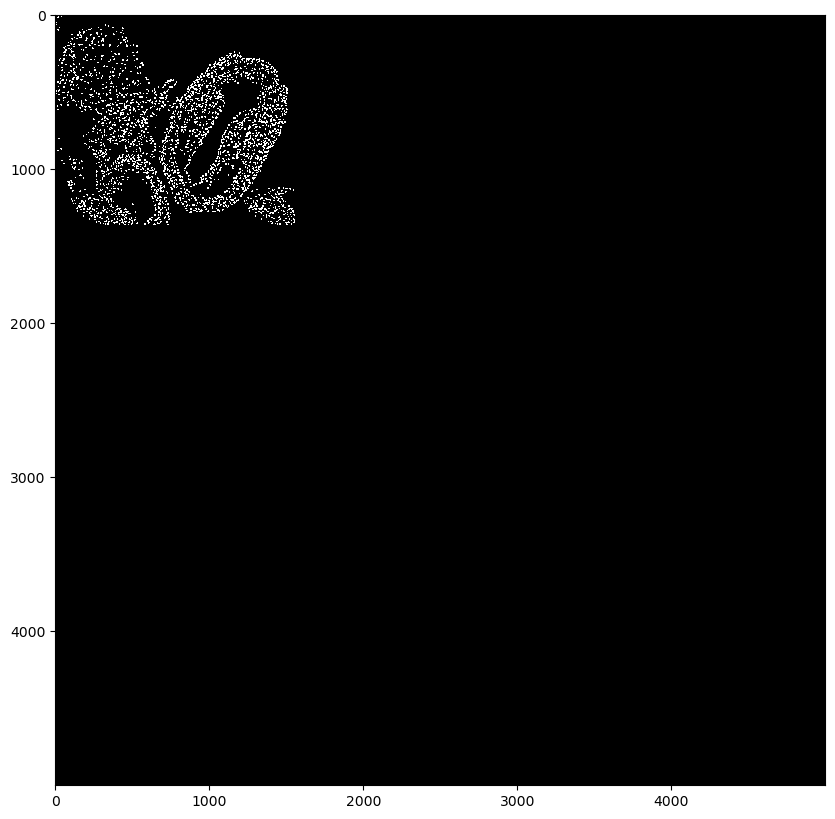

In [69]:
# Plot the filled binary image with black outlines
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(filled_image_new, cmap='gray', interpolation='none')


In [55]:
import numpy as np
from skimage.draw import polygon

# Define the shape of the new mask
mask_shape = (5000, 5000)

# Create a zero-filled mask
filled_image_new = np.zeros(mask_shape, dtype=np.uint8)

# Fill each outline's interior as white
for outline in outlines_1:
    # Move all y-coordinates (outline[:, 1]) down by 1116 units
    outline[:, 1] += 1116
    
    # Ensure the outline coordinates are in integer format
    outline = np.array(outline, dtype=np.int32)
    
    # Get the rows and columns for the interior of each polygon
    rr, cc = polygon(outline[:, 1], outline[:, 0], filled_image_new.shape)
    filled_image_new[rr, cc] = 255  # Fill with white (255) inside each contour


In [59]:
import numpy as np
from skimage.draw import polygon

# Define the shape of the new mask
mask_shape = (5000, 5000)

# Create a zero-filled mask
filled_image_new = np.zeros(mask_shape, dtype=np.uint8)

# Fill each outline's interior as white
for outline in outlines_1:
    # Add [1116, 0] to each coordinate in the outline
    outline = np.array(outline, dtype=np.int32) + np.array([0, 1116], dtype=np.int32)
    
    # Get the rows and columns for the interior of each polygon
    rr, cc = polygon(outline[:, 1], outline[:, 0], filled_image_new.shape)
    filled_image_new[rr, cc] = 255  # Fill with white (255) inside each contour


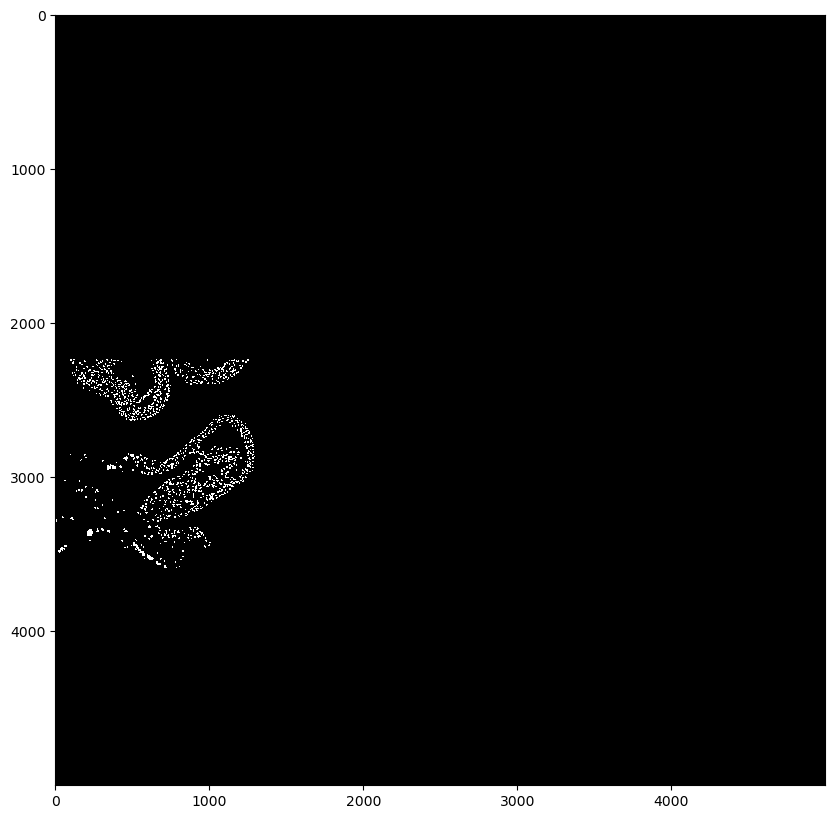

In [60]:
# Plot the filled binary image with black outlines
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(filled_image_new, cmap='gray', interpolation='none')

In [ ]:
# import numpy as np

# Define adjusted main segment coordinates
segments = [
    (0, 1362, 0, 1560),   # Segment 0
    (1116, 2478, 0, 1560) # Segment 1
]

# Offsets for each segment
offsets = [
    (0, 0),               # No offset for Segment 0
    (1116, 0)             # Offset for Segment 1 (row offset, column offset)
]

# New outline list
new_outlines = []


# Function to map segmentation outlines back to original coordinates
def map_to_original_coordinates(outlines, offset):
    """
    Maps segmentation outlines back to the original image coordinates.

    Parameters:
        outlines (list of ndarrays): List of segmentation outlines (N x 2 arrays).
        offset (tuple): Offset (min_x, min_y) of the cropped region in the original image.

    Returns:
        list of ndarrays: Transformed outlines in original coordinates.
    """
    min_x, min_y = offset
    # Fill each outline's interior as white
    for outline in outlines:
        # Add [1116, 0] to each coordinate in the outline
        outline = np.array(outline, dtype=np.int32) + np.array([0, 1116], dtype=np.int32)
    return outline

offset = np.array([1116, 0])  # Add 1116 to rows, 0 to columns

mapped_outlines_0 = map_to_original_coordinates(outlines_0, (0, 0))
new_outlines.extend(mapped_outlines_0)

mapped_outlines_1 = map_to_original_coordinates(outlines_1, (1116, 0))
new_outlines.extend(mapped_outlines_1)

print(f"Generated {len(new_outlines)} adjusted outlines.")